# Training and validation on the Iris dataset (Classification)

In [1]:
import sys
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))
from layers import FullyConnected, Sigmoid, Softmax, ReLU, Dropout
from losses import CrossEntropyLoss
from optimizers import Adam
from network import NeuralNetwork
from trainer import Trainer
from utils import one_hot, normalize, train_val_test_split
from lr_schedulers import StepScheduler, DecayScheduler

np.random.seed(0)

## Load and preprocess the IRIS dataset

### Download the data from the internet

In [2]:
import urllib.request
import numpy as np

# Download IRIS data from UCI if not already present
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_path = "../data/iris.data"
if not os.path.exists(iris_path):
    urllib.request.urlretrieve(iris_url, iris_path)

# Load the data
data = []
labels = []
with open(iris_path, "r") as f:
    for line in f:
        if not line.strip():
            continue
        parts = line.strip().split(",")
        if len(parts) != 5:
            continue
        data.append([float(x) for x in parts[:4]])
        labels.append(parts[4])

### Or: Use the dataset from the data folder

In [3]:
# Unzip and read iris.csv from data/iris.zip
iris_zip_path = '../data/iris.zip'
with zipfile.ZipFile(iris_zip_path, 'r') as z:
    with z.open('Iris.csv') as f:
        data = []
        labels = []
        for i, line in enumerate(f):
            line = line.decode('utf-8')
            if not line.strip(): continue
            parts = line.strip().split(',')
            if i == 0: continue  # skip header
            if len(parts) != 6: continue
            data.append([float(x) for x in parts[1:5]])  # columns 1-4 are features
            labels.append(parts[5])  # column 5 is label

### Preprocess the data

In [4]:
X = np.array(data)
label_names = sorted(list(set(labels)))
label_to_idx = {name: i for i, name in enumerate(label_names)}
y = np.array([label_to_idx[lbl] for lbl in labels])
X = normalize(X)
y_oh = one_hot(y, num_classes=3)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, y_oh, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42)

## Build the network

In [5]:
layers = [
    FullyConnected(4, 8),
    ReLU(),
    FullyConnected(8, 3),
    Softmax()
]
net = NeuralNetwork(layers)
lr = 0.01
decay_rate = 0.005
lr_scheduler = DecayScheduler(initial_lr=lr, decay_rate=decay_rate)
optimizer = Adam(lr=lr, lr_scheduler=lr_scheduler)
loss_fn = CrossEntropyLoss()
trainer = Trainer(net, optimizer, loss_fn)

## Train the network

In [6]:
train_losses, val_losses = trainer.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=16, patience=15)

Epoch 1: train loss=0.8988, val loss=0.8472
Epoch 2: train loss=0.6939, val loss=0.7492
Epoch 3: train loss=0.5691, val loss=0.6427
Epoch 4: train loss=0.4767, val loss=0.5464
Epoch 5: train loss=0.4058, val loss=0.4751
Epoch 6: train loss=0.3764, val loss=0.4149
Epoch 7: train loss=0.3429, val loss=0.3662
Epoch 8: train loss=0.3037, val loss=0.3445
Epoch 9: train loss=0.2708, val loss=0.3141
Epoch 10: train loss=0.2573, val loss=0.2829
Epoch 11: train loss=0.2306, val loss=0.2632
Epoch 12: train loss=0.2162, val loss=0.2428
Epoch 13: train loss=0.2038, val loss=0.2256
Epoch 14: train loss=0.1953, val loss=0.2125
Epoch 15: train loss=0.1853, val loss=0.2017
Epoch 16: train loss=0.1740, val loss=0.1891
Epoch 17: train loss=0.1654, val loss=0.1845
Epoch 18: train loss=0.1629, val loss=0.1781
Epoch 19: train loss=0.1509, val loss=0.1659
Epoch 20: train loss=0.1592, val loss=0.1604
Epoch 21: train loss=0.1501, val loss=0.1556
Epoch 22: train loss=0.1422, val loss=0.1498
Epoch 23: train los

## Visualize training and validation losses

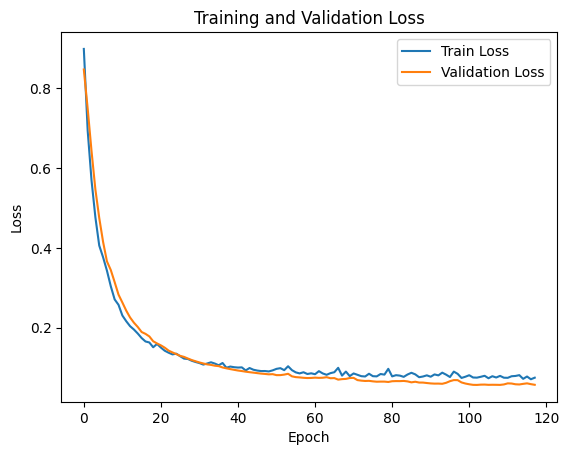

In [7]:
if train_losses is not None:
    plt.plot(train_losses, label='Train Loss')
if val_losses is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluate on test set

In [8]:
out = net.forward(X_test)
preds = np.argmax(out, axis=1)
labels = np.argmax(y_test, axis=1)
accuracy = np.mean(preds == labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Test accuracy: 95.65%


## Confusion Matrix

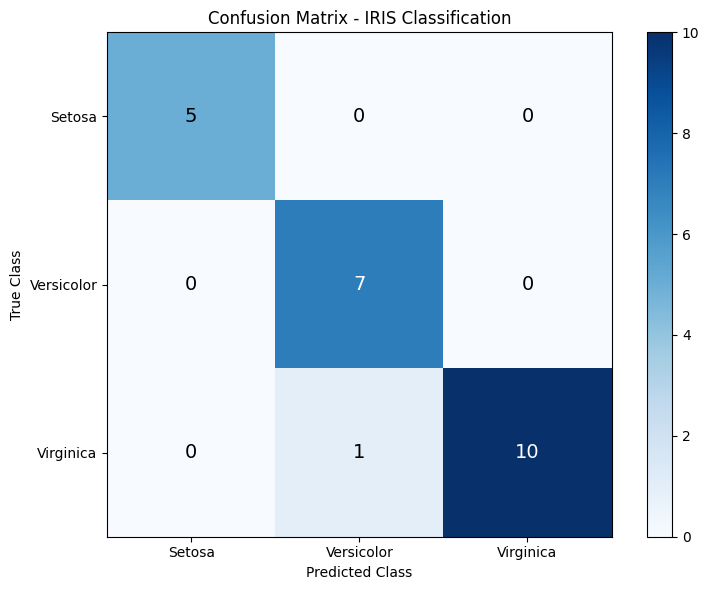

In [9]:
# Create confusion matrix
def create_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm

cm = create_confusion_matrix(labels, preds, 3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - IRIS Classification')
plt.colorbar()

# Add text annotations
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', 
                fontsize=14, color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks([0, 1, 2], ['Setosa', 'Versicolor', 'Virginica'])
plt.yticks([0, 1, 2], ['Setosa', 'Versicolor', 'Virginica'])
plt.tight_layout()
plt.show()

## Other statistics from the testing

In [10]:
# Print detailed classification report
print("\nClassification Report:")
print("Class        Precision  Recall  F1-Score  ")
print("-" * 50)
class_names = ['Setosa', 'Versicolor', 'Virginica']
for i in range(3):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    support = np.sum(cm[i, :])
    print(f"{class_names[i]:<12} {precision:.3f}      {recall:.3f}   {f1:.3f} ")


Classification Report:
Class        Precision  Recall  F1-Score  
--------------------------------------------------
Setosa       1.000      1.000   1.000 
Versicolor   0.875      1.000   0.933 
Virginica    1.000      0.909   0.952 
